# 📈 Retail Demand Forecasting with LSTM (Keras)

In [2]:
!pip install tensorflow


In [5]:
!pip -q install timesfm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.0/55.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.0 MB/s eta 0:00:00


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from timesfm import TimesFm, TimesFmHparams, TimesFmCheckpoint
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Fix seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0].


## 📦 Load or generate dataset

In [7]:

# Load or generate dataset
try:
    df = pd.read_csv("../data/train.csv", parse_dates=["date"])
except:
    date_rng = pd.date_range(start='2020-01-01', end='2022-01-01', freq='D')
    df = pd.DataFrame(date_rng, columns=['date'])
    df['sales'] = 50 + np.sin(np.linspace(0, 20 * np.pi, len(df))) * 10 + np.random.normal(0, 3, len(df))

df = df[['date', 'sales']]
df.columns = ['ds', 'y']
df.set_index('ds', inplace=True)
df.head()


,y
ds,
2020-01-01,51.490142
2020-01-02,50.443682
2020-01-03,53.653677
2020-01-04,57.119207
2020-01-05,52.668335


## 🔄 Preprocessing for LSTM

In [8]:

# Normalize the data
scaler = MinMaxScaler()
df['y_scaled'] = scaler.fit_transform(df[['y']])

# Create sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 30
data = df['y_scaled'].values
X, y = create_sequences(data, window_size)

# Train/test split
split = int(0.85 * len(X))
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

# Reshape for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


## 🧠 Define and train the LSTM model

In [9]:

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_split=0.1, verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.1506 - val_loss: 0.0381
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0271 - val_loss: 0.0213
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0192 - val_loss: 0.0127
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0119 - val_loss: 0.0117
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0110 - val_loss: 0.0116
Epoch 6/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0109 - val_loss: 0.0116
Epoch 7/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0110 - val_loss: 0.0116
Epoch 8/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0110 - val_loss: 0.0118
Epoch 9/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0109 - val_loss: 0.0118
Epoch 10/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0109 - val_loss: 0.0119
Epoch 11/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0108 - val_loss: 0.0118
Epoch 12/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0108 - val_l


## 📈 Evaluate the model

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 303ms/step
[LSTM] MAE: 2.55, RMSE: 3.27


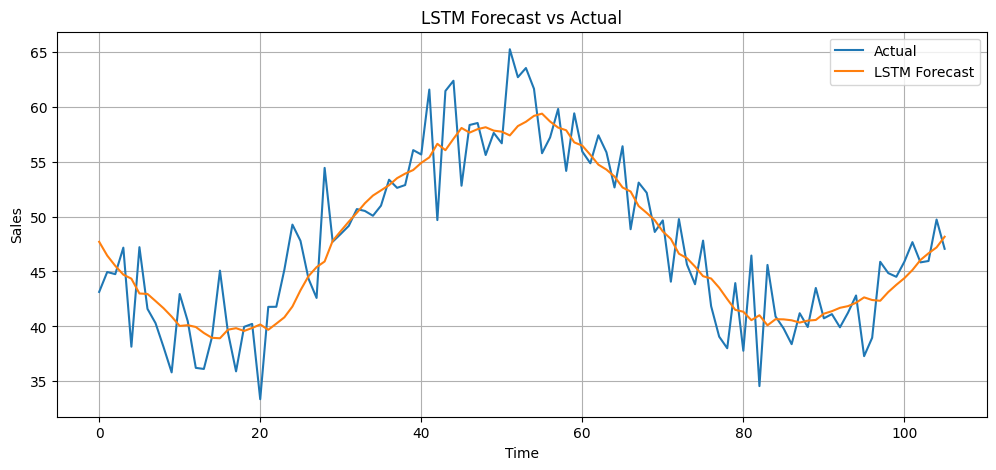

In [10]:

# Predict
y_pred = model.predict(X_test)

# Inverse transform
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = math.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

print(f"[LSTM] MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# Plot
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='LSTM Forecast')
plt.title("LSTM Forecast vs Actual")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.legend()
plt.grid()
plt.show()


## 🔄 Preprocessing for Timesfm

In [12]:
# Create sliding sequences for LSTM-style forecasting

def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 30
data = df['y_scaled'].values
X, y_seq = create_sequences(data, window_size)

# Train/test split (same logic as LSTM training)
split = int(0.85 * len(X))  # 85% train, 15% test
forecast_start_idx = split + window_size  # actual index of first y_test
h = len(y_seq) - split  # forecasting horizon = test set size

# Prepare TimesFM-compatible dataframe
df_timesfm = df[['ds', 'y_scaled']].copy()
df_timesfm.rename(columns={'y_scaled': 'y'}, inplace=True)
df_timesfm['unique_id'] = 1  # required by TimesFM format

train_df = df_timesfm.iloc[:forecast_start_idx].copy()
test_df = df_timesfm.iloc[forecast_start_idx:forecast_start_idx + h].copy()


## 📈 Initialize TimesFM model

In [13]:
tfm = TimesFm(
    hparams=TimesFmHparams(
        per_core_batch_size=32,
        horizon_len=h,
        num_layers=50,
        use_positional_embedding=False,
        context_len=512,
    ),
    checkpoint=TimesFmCheckpoint(huggingface_repo_id="google/timesfm-2.0-500m-pytorch")
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

.gitattributes: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/692 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

torch_model.ckpt:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

## 🧠 Forecast with TimesFM

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
✅ Forecast completed in 5.26 sec
[TimesFM - same test set as LSTM] MAE: 2.49, RMSE: 3.02


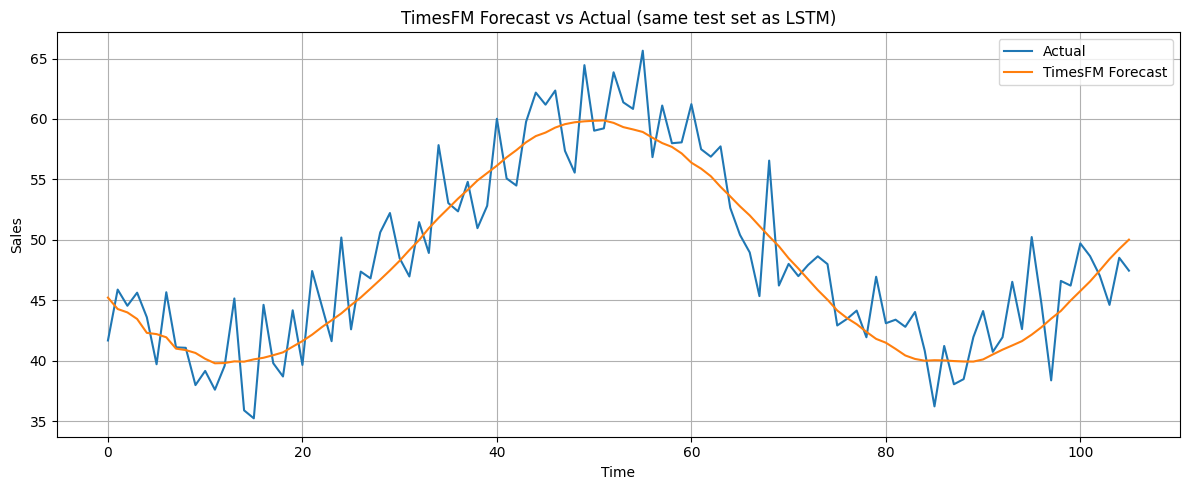

In [15]:
start = time.time()
forecast = tfm.forecast_on_df(
    inputs=train_df,
    freq="D",  # daily frequency
    value_name="y",
    num_jobs=-1,  # use all CPU cores
)
end = time.time()
print(f"✅ Forecast completed in {end - start:.2f} sec")

# Inverse scale and evaluate the forecast

forecast_df = forecast[["ds", "timesfm"]].copy()
forecast_df.columns = ["ds", "y_pred_scaled"]

# Reverse the MinMax scaling
y_pred = scaler.inverse_transform(forecast_df["y_pred_scaled"].values.reshape(-1, 1))
y_true = scaler.inverse_transform(test_df["y"].values.reshape(-1, 1))

# Compute evaluation metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = math.sqrt(mean_squared_error(y_true, y_pred))
print(f"[TimesFM - same test set as LSTM] MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# Visualization: TimesFM forecast vs Actual

plt.figure(figsize=(12, 5))
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='TimesFM Forecast')
plt.title("TimesFM Forecast vs Actual (same test set as LSTM)")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


## 📊 Forecast Comparison

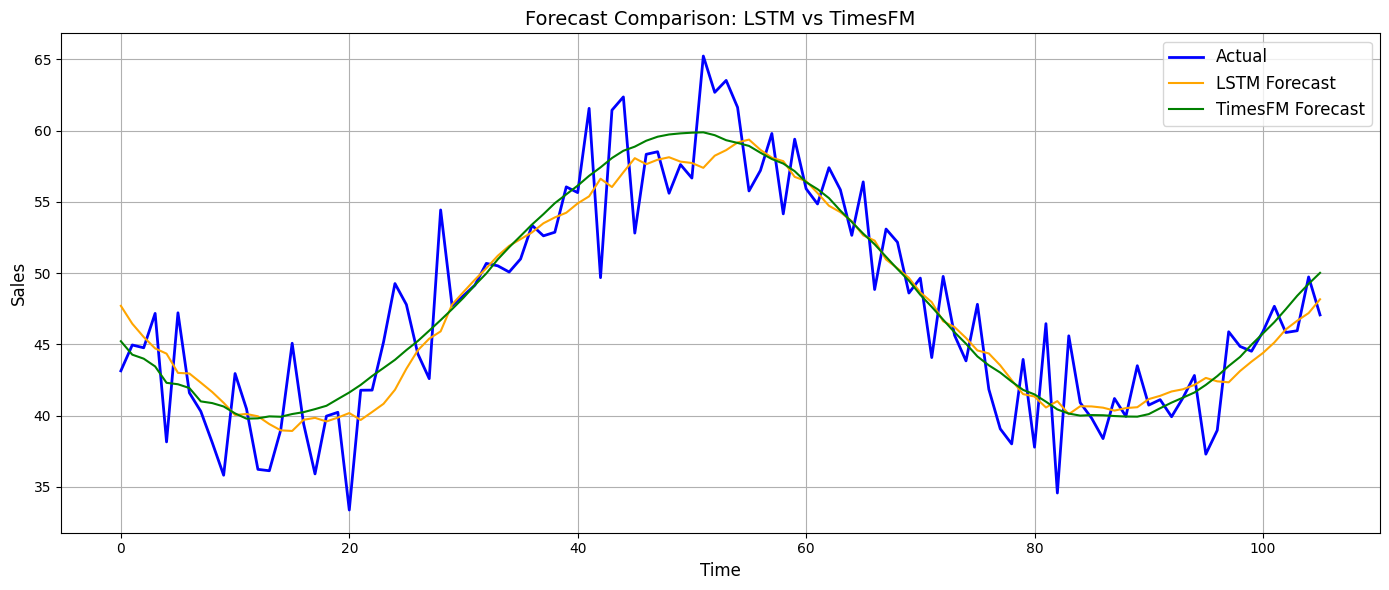

In [16]:
# Plotting LSTM vs TimesFM Forecasts
plt.figure(figsize=(14, 6))

plt.plot(y_test_inv, label='Actual', color='blue', linewidth=2)
plt.plot(y_pred_inv, label='LSTM Forecast', color='orange')
plt.plot(y_pred, label='TimesFM Forecast', color='green')

plt.title("Forecast Comparison: LSTM vs TimesFM", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig("forecast_comparison_lstm.png", dpi=300, bbox_inches='tight')

plt.show()
